<a href="https://colab.research.google.com/github/swilsonmfc/deeplearning/blob/master/CatsDogsKerasClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cats & Dogs - Classification
* Take the Kaggle Cats & Dogs competition data
* Build up a simple Convnet
* Train from subset of images & predict on test 
* Add data augmentation & dropout to improve

# Setup

In [0]:
from zipfile import ZipFile
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [0]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator 

1.15.0


Using TensorFlow backend.


# Image Data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!ls "/content/drive/My Drive/Data/CatsDogs/data.zip"
file   = "/content/drive/My Drive/Data/CatsDogs/data.zip"

'/content/drive/My Drive/Data/CatsDogs/data.zip'


## Extract Zip

In [0]:
!mkdir -p /tmp/catdog
with ZipFile(file, 'r') as zip: 
  zip.extractall('/tmp/catdog/')

## Setup Folders

In [0]:
base_dir       = '/tmp/catdog/'
test_dir       = '/tmp/catdog/test/'
training_dir   = '/tmp/catdog/training/'
validation_dir = '/tmp/catdog/validation/'

!mkdir -p "$base_dir"

!rm -fr "$test_dir"
!mkdir -p "$test_dir"
!mkdir -p "$test_dir/cats"
!mkdir -p "$test_dir/dogs"

!rm -fr "$training_dir"
!mkdir -p "$training_dir"
!mkdir -p "$training_dir/cats"
!mkdir -p "$training_dir/dogs"

!rm -fr "$validation_dir"
!mkdir -p "$validation_dir"
!mkdir -p "$validation_dir/cats"
!mkdir -p "$validation_dir/dogs"

## Images

In [0]:
range_train = 1000
range_validation = 1500
range_test = 2000

In [0]:
def copyFiles(prefix, dest, start, end):
  if prefix != 'cat' and prefix != 'dog':
    raise ValueError('Must pass cat or dog for prefix')
  srcFolder  = os.path.join(base_dir, 'train')
  destFolder = os.path.join(base_dir, dest, prefix + 's')
  print(srcFolder, '->', destFolder, start, end)
  for file in  ['{}.{}.jpg'.format(prefix, index) for index in range(start, end)]:
    shutil.copy(os.path.join(srcFolder, file), os.path.join(destFolder, file))

In [0]:
copyFiles('cat', 'training', 0, range_train)
copyFiles('cat', 'validation', range_train, range_validation)
copyFiles('cat', 'test', range_validation, range_test)

copyFiles('dog', 'training', 0, range_train)
copyFiles('dog', 'validation', range_train, range_validation)
copyFiles('dog', 'test', range_validation, range_test)

/tmp/catdog/train -> /tmp/catdog/training/cats 0 1000
/tmp/catdog/train -> /tmp/catdog/validation/cats 1000 1500
/tmp/catdog/train -> /tmp/catdog/test/cats 1500 2000
/tmp/catdog/train -> /tmp/catdog/training/dogs 0 1000
/tmp/catdog/train -> /tmp/catdog/validation/dogs 1000 1500
/tmp/catdog/train -> /tmp/catdog/test/dogs 1500 2000


In [0]:
!ls /tmp/catdog/training/dogs

dog.0.jpg    dog.250.jpg  dog.400.jpg  dog.551.jpg  dog.701.jpg  dog.852.jpg
dog.100.jpg  dog.251.jpg  dog.401.jpg  dog.552.jpg  dog.702.jpg  dog.853.jpg
dog.101.jpg  dog.252.jpg  dog.402.jpg  dog.553.jpg  dog.703.jpg  dog.854.jpg
dog.102.jpg  dog.253.jpg  dog.403.jpg  dog.554.jpg  dog.704.jpg  dog.855.jpg
dog.103.jpg  dog.254.jpg  dog.404.jpg  dog.555.jpg  dog.705.jpg  dog.856.jpg
dog.104.jpg  dog.255.jpg  dog.405.jpg  dog.556.jpg  dog.706.jpg  dog.857.jpg
dog.105.jpg  dog.256.jpg  dog.406.jpg  dog.557.jpg  dog.707.jpg  dog.858.jpg
dog.106.jpg  dog.257.jpg  dog.407.jpg  dog.558.jpg  dog.708.jpg  dog.859.jpg
dog.107.jpg  dog.258.jpg  dog.408.jpg  dog.559.jpg  dog.709.jpg  dog.85.jpg
dog.108.jpg  dog.259.jpg  dog.409.jpg  dog.55.jpg   dog.70.jpg	 dog.860.jpg
dog.109.jpg  dog.25.jpg   dog.40.jpg   dog.560.jpg  dog.710.jpg  dog.861.jpg
dog.10.jpg   dog.260.jpg  dog.410.jpg  dog.561.jpg  dog.711.jpg  dog.862.jpg
dog.110.jpg  dog.261.jpg  dog.411.jpg  dog.562.jpg  dog.712.jpg  dog.863.jpg
d

# Model

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 15, 15, 128)      

# Compile Model
* Learning rate too large, you'll stall on 0.5 accuracy, too small requires more epochs

In [0]:
model.compile(loss='binary_crossentropy', 
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])

# Pre-Processing

In [0]:
train_datagen      = ImageDataGenerator(rescale=1. / 255)
validation_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen       = ImageDataGenerator(rescale=1. / 255)

print(training_dir)
train_gen = train_datagen.flow_from_directory(
  training_dir,
  target_size=(150, 150),
  batch_size=20,
  class_mode='binary')

print(validation_dir)
validation_gen = validation_datagen.flow_from_directory(
  validation_dir,
  target_size=(150, 150),
  batch_size=20,
  class_mode='binary')

print(test_dir)
test_gen = test_datagen.flow_from_directory(
  test_dir,
  target_size=(150, 150),
  batch_size=20,
  class_mode='binary', 
  shuffle=False) # Don't shuffle predictions

/tmp/catdog/training/
Found 2000 images belonging to 2 classes.
/tmp/catdog/validation/
Found 1000 images belonging to 2 classes.
/tmp/catdog/test/
Found 1000 images belonging to 2 classes.


# Fit Model

In [0]:
history = model.fit_generator(
  train_gen,
  steps_per_epoch=100,
  epochs=30,
  validation_data=validation_gen,
  validation_steps=50)
model.save('cats_and_dogs_small_1.h5')

Epoch 1/30
100/100 [==============================] - 12s 121ms/step - loss: 0.6883 - acc: 0.5325 - val_loss: 0.6831 - val_acc: 0.5140
Epoch 2/30
100/100 [==============================] - 11s 106ms/step - loss: 0.6532 - acc: 0.6195 - val_loss: 0.6356 - val_acc: 0.6300
Epoch 3/30
100/100 [==============================] - 11s 105ms/step - loss: 0.6134 - acc: 0.6770 - val_loss: 0.5989 - val_acc: 0.6600
Epoch 4/30
100/100 [==============================] - 11s 110ms/step - loss: 0.5622 - acc: 0.6935 - val_loss: 0.6767 - val_acc: 0.6190
Epoch 5/30
100/100 [==============================] - 11s 111ms/step - loss: 0.5365 - acc: 0.7305 - val_loss: 0.5815 - val_acc: 0.6780
Epoch 6/30
100/100 [==============================] - 11s 113ms/step - loss: 0.5029 - acc: 0.7565 - val_loss: 0.5865 - val_acc: 0.6900
Epoch 7/30
100/100 [==============================] - 11s 111ms/step - loss: 0.4832 - acc: 0.7600 - val_loss: 0.5563 - val_acc: 0.7070
Epoch 8/30
100/100 [==============================] - 1

# Plot Loss & Accuracy

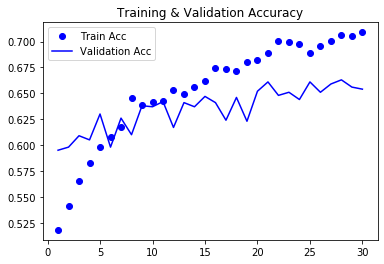

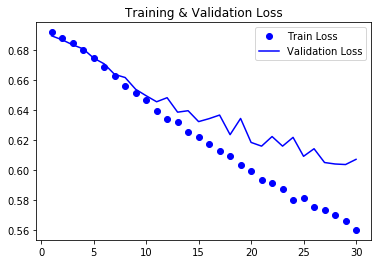

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Train Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Train Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

# Test Accuracy

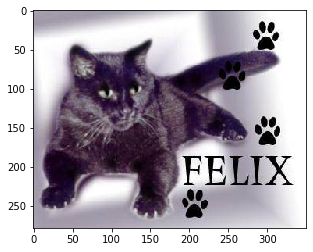

In [0]:
img = mpimg.imread('/tmp/catdog/test/cats/cat.1501.jpg')
imgplot = plt.imshow(img)
plt.show()

In [0]:
test_loss, test_acc = model.evaluate_generator(test_gen, steps=50)
print('Test Accuracy {:.3f}'.format(test_acc))
print('Test Loss {:.3f}'.format(test_loss))

Test Accuracy 0.728
Test Loss 0.939


# Predictions

In [0]:
preds = model.predict_generator(test_gen, steps=50)

In [0]:
y_true = np.array([0] * 500 + [1] * 500)
y_pred = preds > 0.5

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[380 120]
 [152 348]]
              precision    recall  f1-score   support

           0       0.71      0.76      0.74       500
           1       0.74      0.70      0.72       500

    accuracy                           0.73      1000
   macro avg       0.73      0.73      0.73      1000
weighted avg       0.73      0.73      0.73      1000



# Data Augmentation
* To improve on a simple Convnet, we'll attempt to augment the data and increase "regularization" by adding dropout
* Augmentation
  * We can flip / rotate and randomly adjust existing images to improve our accuracy
  * Ideally, our net will never see the same image twice
* Dropout
  * Fights overfitting
  * Forces the network to rely and create different "features" to classify


In [0]:
data_aug_gen = ImageDataGenerator(rescale = 1./255,
                               rotation_range=40,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,)

train_aug_gen = data_aug_gen.flow_from_directory(training_dir,
                                           target_size=(150, 150),
                                           batch_size=32,
                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


# Dropout & Model

In [0]:
model_aug = models.Sequential()
model_aug.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model_aug.add(layers.MaxPooling2D((2, 2)))
model_aug.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_aug.add(layers.MaxPooling2D((2, 2)))
model_aug.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_aug.add(layers.MaxPooling2D((2, 2)))
model_aug.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_aug.add(layers.MaxPooling2D((2, 2)))
model_aug.add(layers.Flatten())
model_aug.add(layers.Dropout(0.5))
model_aug.add(layers.Dense(512, activation='relu'))
model_aug.add(layers.Dense(1, activation='sigmoid'))

model_aug.summary()

model_aug.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])

model_aug.fit_generator(
  train_aug_gen,
  steps_per_epoch=100,
  epochs=100,
  validation_data=validation_gen,
  validation_steps=50)
model_aug.save('cats_and_dogs_small_2.h5')

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 15, 15, 128)      

In [0]:
test_loss, test_acc = model_aug.evaluate_generator(test_gen, steps=50)
print('Test Accuracy {:.3f}'.format(test_acc))
print('Test Loss {:.3f}'.format(test_loss))

Test Accuracy 0.809
Test Loss 0.427


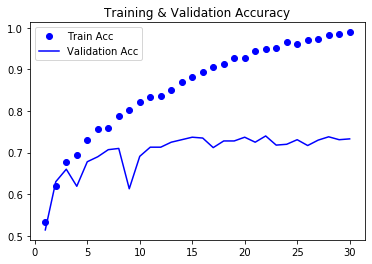

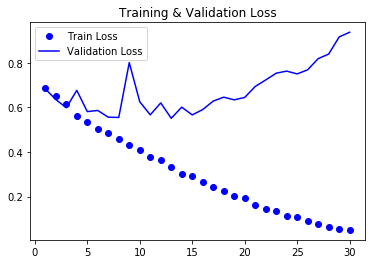

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Train Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Train Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

# Takeaways
* Even on this small net, use a GPU
* The data is small, you'll be fighting overfitting
* A convnet trained from scratch on a dataset will perform well
* There are additional techniques to continue improving:
  * Data Augmentation
  * Reuse Existing Convnet
  * Fine Tuning Existing Convnet
* Got a 10% improvement in test accuracy with augmenting and using dropout
* Could continue to tune adding more layers / dropout